In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
import seaborn as sns
from PIL import Image

2025-05-18 12:46:34.256100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747572394.442768      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747572394.496778      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 1. Thiết lập đường dẫn
organized_data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
nih_data_dir = "/kaggle/input/data"
nih_metadata_path = os.path.join(nih_data_dir, "Data_Entry_2017.csv")
chest_xray_data = "/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset"
covid19_peumonia = "/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset"
pneumonia_chest_xrays = "/kaggle/input/pneumonia-chest-xrays/Pneumonia_Chest_Xray"
tb_chest = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"

In [4]:
# 2. Chuẩn bị dữ liệu NIH
print("Preparing NIH dataset...")
nih_df = pd.read_csv(nih_metadata_path)
nih_df = nih_df[nih_df['Finding Labels'].isin(['No Finding', 'Pneumonia'])]
nih_df['label'] = nih_df['Finding Labels'].apply(lambda x: 'NORMAL' if x == 'No Finding' else 'PNEUMONIA')
nih_df['class'] = nih_df['Finding Labels'].apply(lambda x: 0 if x == 'No Finding' else 1)

# Cân bằng dữ liệu NIH
normal_df = nih_df[nih_df['label'] == 'NORMAL'].sample(n=5000, random_state=42)
pneumonia_df = nih_df[nih_df['label'] == 'PNEUMONIA']
nih_df = pd.concat([normal_df, pneumonia_df])
print(f"NIH dataset - Balanced class distribution:\n{nih_df['label'].value_counts()}")

Preparing NIH dataset...
NIH dataset - Balanced class distribution:
label
NORMAL       5000
PNEUMONIA     322
Name: count, dtype: int64


In [5]:
# Tìm đường dẫn ảnh NIH
def get_full_image_path(image_filename, image_subdirs):
    for subdir in image_subdirs:
        path1 = os.path.join(subdir, image_filename)
        path2 = os.path.join(subdir, "images", image_filename)
        if os.path.exists(path1):
            return path1
        elif os.path.exists(path2):
            return path2
    return None

nih_image_dirs = glob.glob(os.path.join(nih_data_dir, "images_*"))
nih_df['image_path'] = nih_df['Image Index'].apply(lambda x: get_full_image_path(x, nih_image_dirs))
nih_df = nih_df.dropna(subset=['image_path'])

In [6]:
# 3. Chuẩn bị dữ liệu từ các dataset khác
def collect_image_paths_from_dir(root_dir):
    collected_paths = []
    labels = []
    subdirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    label_map = {}
    for subdir in subdirs:
        lower_name = subdir.lower()
        if "normal" in lower_name:
            label_map[subdir] = "NORMAL"
        elif "pneumonia" in lower_name:
            label_map[subdir] = "PNEUMONIA"
    for subdir, label in label_map.items():
        full_dir = os.path.join(root_dir, subdir)
        image_files = glob.glob(os.path.join(full_dir, "*.jpg")) + \
                      glob.glob(os.path.join(full_dir, "*.jpeg")) + \
                      glob.glob(os.path.join(full_dir, "*.png"))
        collected_paths.extend(image_files)
        labels.extend([label] * len(image_files))
    return pd.DataFrame({'image_path': collected_paths, 'label': labels})

other_datasets_df = pd.DataFrame()
for dataset_path in [chest_xray_data, covid19_peumonia, pneumonia_chest_xrays, tb_chest]:
    df = collect_image_paths_from_dir(dataset_path)
    other_datasets_df = pd.concat([other_datasets_df, df], ignore_index=True)
other_datasets_df['class'] = other_datasets_df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1)
print(f"Other datasets - Class distribution:\n{other_datasets_df['label'].value_counts()}")

# Chia tập dữ liệu khác
other_train, other_test = train_test_split(other_datasets_df, test_size=0.4, stratify=other_datasets_df['label'], random_state=42)
other_test, other_val = train_test_split(other_test, test_size=0.5, stratify=other_test['label'], random_state=42)

Other datasets - Class distribution:
label
PNEUMONIA    10859
NORMAL        8979
Name: count, dtype: int64


In [7]:
# 4. Dataset PyTorch
class XRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['class']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        image = self.processor(image, return_tensors="pt")['pixel_values'].squeeze(0)
        return image, label

# Transform cho dữ liệu
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.1, scale=(0.9, 1.1)),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:
# 1. Hàm kiểm tra sự mất cân bằng dữ liệu
def check_data_imbalance(df, label_column='label', plot=True, verbose=True):
    try:
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input 'df' must be a pandas DataFrame.")
        if label_column not in df.columns:
            raise ValueError(f"Column '{label_column}' not found in DataFrame.")
        
        class_counts = df[label_column].value_counts()
        total_samples = len(df)
        class_ratios = (class_counts / total_samples * 100).round(2)
        max_count = class_counts.max()
        min_count = class_counts.min()
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
        
        if verbose:
            print("\n=== Data Imbalance Analysis ===")
            print(f"Total samples: {total_samples}")
            print("\nClass Counts:")
            for cls, count in class_counts.items():
                print(f"  {cls}: {count} samples ({class_ratios[cls]}%)")
            print(f"\nImbalance Ratio (majority/minority): {imbalance_ratio:.2f}")
            if imbalance_ratio > 2:
                print("Warning: Data is significantly imbalanced (ratio > 2). Consider balancing techniques.")
            else:
                print("Data is relatively balanced (ratio <= 2).")
        
        if plot:
            plt.figure(figsize=(8, 6))
            sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
            plt.title('Class Distribution')
            plt.xlabel('Class')
            plt.ylabel('Number of Samples')
            for i, count in enumerate(class_counts.values):
                plt.text(i, count + 0.01 * max_count, str(count), ha='center', va='bottom')
            plt.tight_layout()
            plt.show()
        
        return {
            'class_counts': class_counts.to_dict(),
            'class_ratios': class_ratios.to_dict(),
            'imbalance_ratio': imbalance_ratio,
            'total_samples': total_samples
        }
    
    except Exception as e:
        print(f"Error checking data imbalance: {e}")
        return None

In [9]:
def inspect_dataloaders(train_loader, val_loader, test_loader, num_samples=3):
    """
    Kiểm tra dữ liệu trong train_loader, val_loader, test_loader.
    
    Parameters:
    - train_loader, val_loader, test_loader: DataLoader objects
    - num_samples: Số mẫu để hiển thị từ mỗi loader
    """
    try:
        # Kiểm tra kích thước dataset
        print("\n=== Dataset Sizes ===")
        print(f"Training set: {len(train_loader.dataset)} samples")
        print(f"Validation set: {len(val_loader.dataset)} samples")
        print(f"Test set: {len(test_loader.dataset)} samples")
        
        # Kiểm tra sự mất cân bằng
        print("\n=== Class Distribution ===")
        for name, loader in [("Training", train_loader), ("Validation", val_loader), ("Test", test_loader)]:
            df = loader.dataset.df
            print(f"\n{name} Set:")
            check_data_imbalance(df, label_column='label', plot=True, verbose=True)
        
        # Hiển thị mẫu ảnh
        def plot_samples(loader, name, num_samples):
            images, labels = next(iter(loader))
            images = images[:num_samples]
            labels = labels[:num_samples]
            plt.figure(figsize=(15, 5))
            for i in range(num_samples):
                img = images[i].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalize for display
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img)
                plt.title(f"{'PNEUMONIA' if labels[i].item() == 1 else 'NORMAL'}")
                plt.axis('off')
            plt.suptitle(f"{name} Set Samples")
            plt.tight_layout()
            plt.show()
        
        print("\n=== Sample Images ===")
        plot_samples(train_loader, "Training", num_samples)
        plot_samples(val_loader, "Validation", num_samples)
        plot_samples(test_loader, "Test", num_samples)
        
        # Kiểm tra thuộc tính ảnh
        print("\n=== Image Properties ===")
        for name, loader in [("Training", train_loader), ("Validation", val_loader), ("Test", test_loader)]:
            images, labels = next(iter(loader))
            print(f"\n{name} Set:")
            print(f"  Image shape: {images.shape}")  # Expected: [batch_size, 3, 224, 224]
            print(f"  Pixel value range: [{images.min().item():.4f}, {images.max().item():.4f}]")
            print(f"  Label shape: {labels.shape}")  # Expected: [batch_size]
            print(f"  Unique labels: {np.unique(labels.numpy())}")
    
    except Exception as e:
        print(f"Error inspecting dataloaders: {e}")
        print("Please ensure train_loader, val_loader, and test_loader are properly defined.")


In [10]:
# 5. Tạo DataLoader
def setup_dataloaders(batch_size=64):
    # Organized dataset
    org_train_df = collect_image_paths_from_dir(os.path.join(organized_data_dir, "train"))
    org_val_df = collect_image_paths_from_dir(os.path.join(organized_data_dir, "val"))
    org_test_df = collect_image_paths_from_dir(os.path.join(organized_data_dir, "test"))
    org_train_df['class'] = org_train_df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1)
    org_val_df['class'] = org_val_df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1)
    org_test_df['class'] = org_test_df['label'].apply(lambda x: 0 if x == 'NORMAL' else 1)

    # Combine datasets
    train_df = pd.concat([org_train_df, nih_df, other_train], ignore_index=True)
    val_df = pd.concat([org_val_df, other_val], ignore_index=True)
    test_df = pd.concat([org_test_df, other_test], ignore_index=True)

    train_dataset = XRayDataset(train_df, transform=train_transform)
    val_dataset = XRayDataset(val_df, transform=val_transform)
    test_dataset = XRayDataset(test_df, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

batch_size = 64
train_loader, val_loader, test_loader = setup_dataloaders(batch_size)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]


=== Dataset Sizes ===
Training set: 22440 samples
Validation set: 3984 samples
Test set: 4592 samples

=== Class Distribution ===

Training Set:

=== Data Imbalance Analysis ===
Total samples: 22440

Class Counts:
  NORMAL: 11728 samples (52.26%)
  PNEUMONIA: 10712 samples (47.74%)

Imbalance Ratio (majority/minority): 1.09
Data is relatively balanced (ratio <= 2).


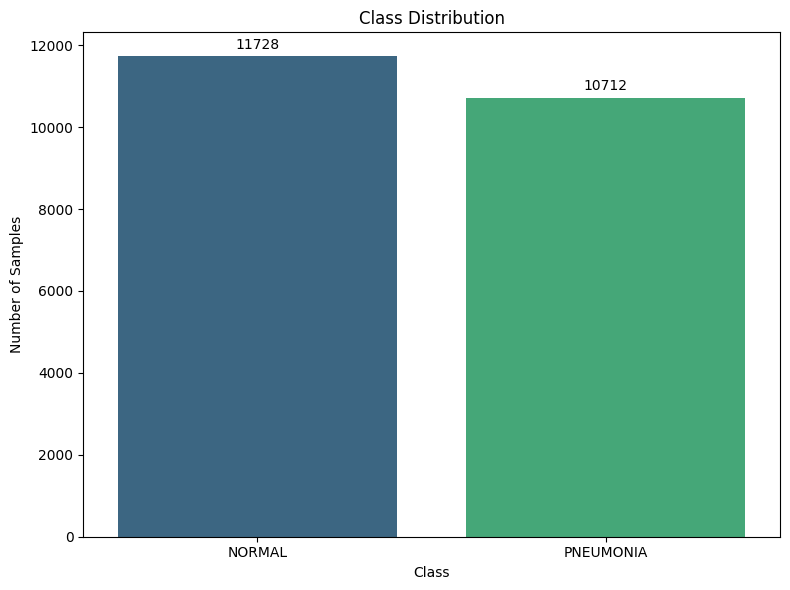


Validation Set:

=== Data Imbalance Analysis ===
Total samples: 3984

Class Counts:
  PNEUMONIA: 2180 samples (54.72%)
  NORMAL: 1804 samples (45.28%)

Imbalance Ratio (majority/minority): 1.21
Data is relatively balanced (ratio <= 2).


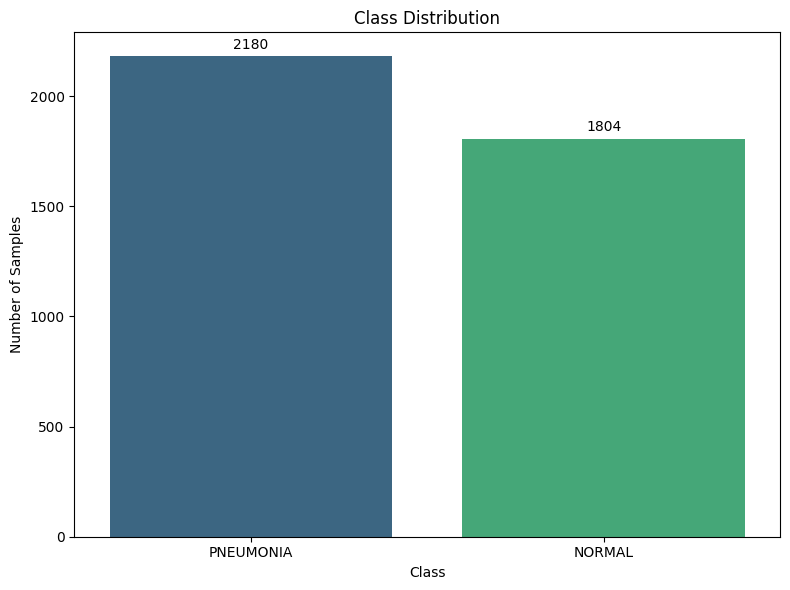


Test Set:

=== Data Imbalance Analysis ===
Total samples: 4592

Class Counts:
  PNEUMONIA: 2562 samples (55.79%)
  NORMAL: 2030 samples (44.21%)

Imbalance Ratio (majority/minority): 1.26
Data is relatively balanced (ratio <= 2).


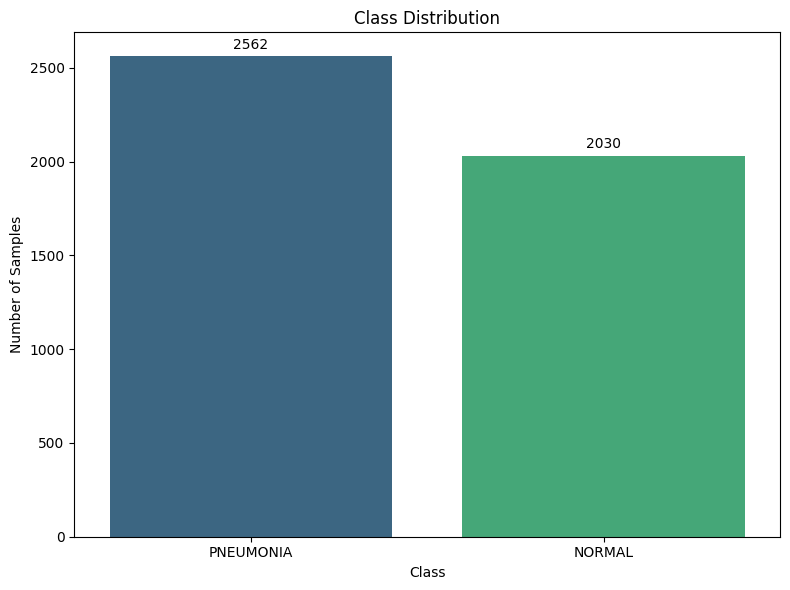


=== Sample Images ===


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


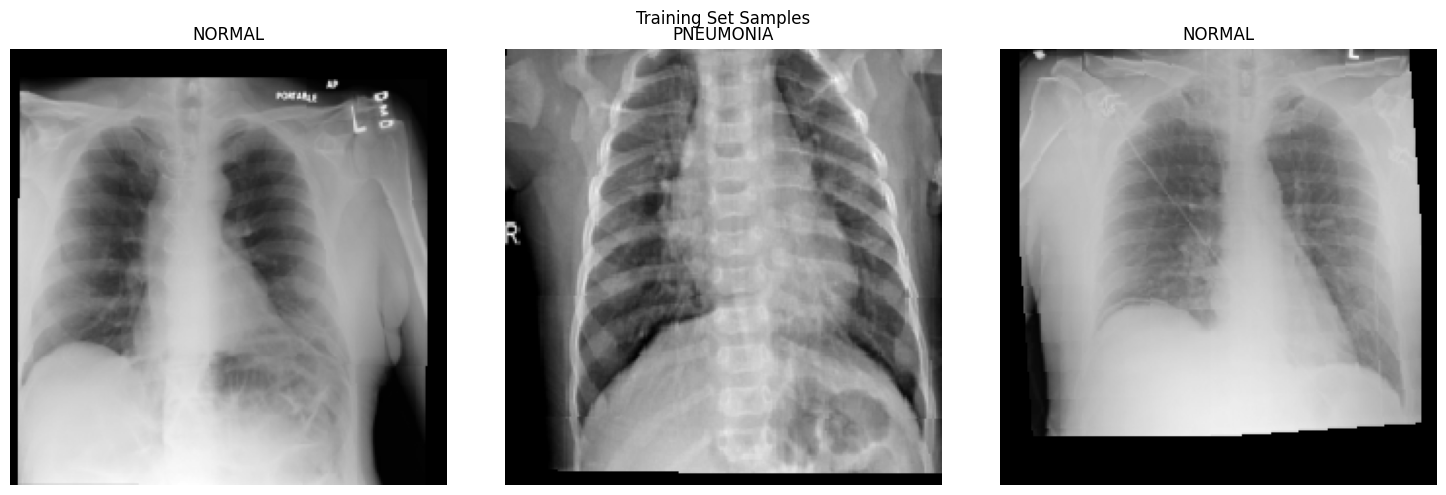

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


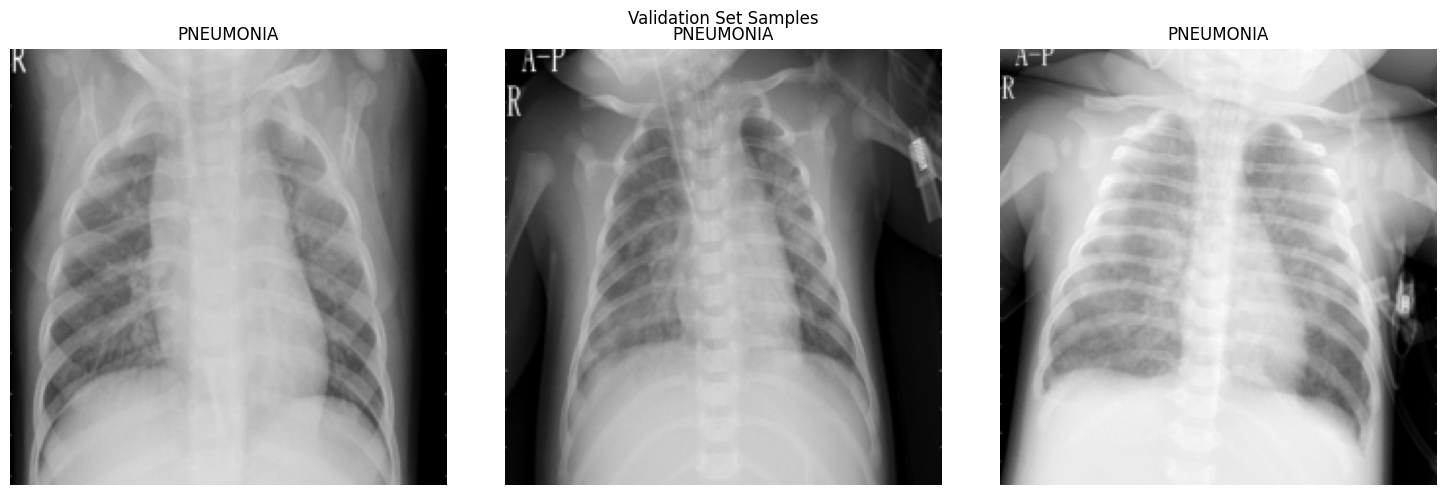

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


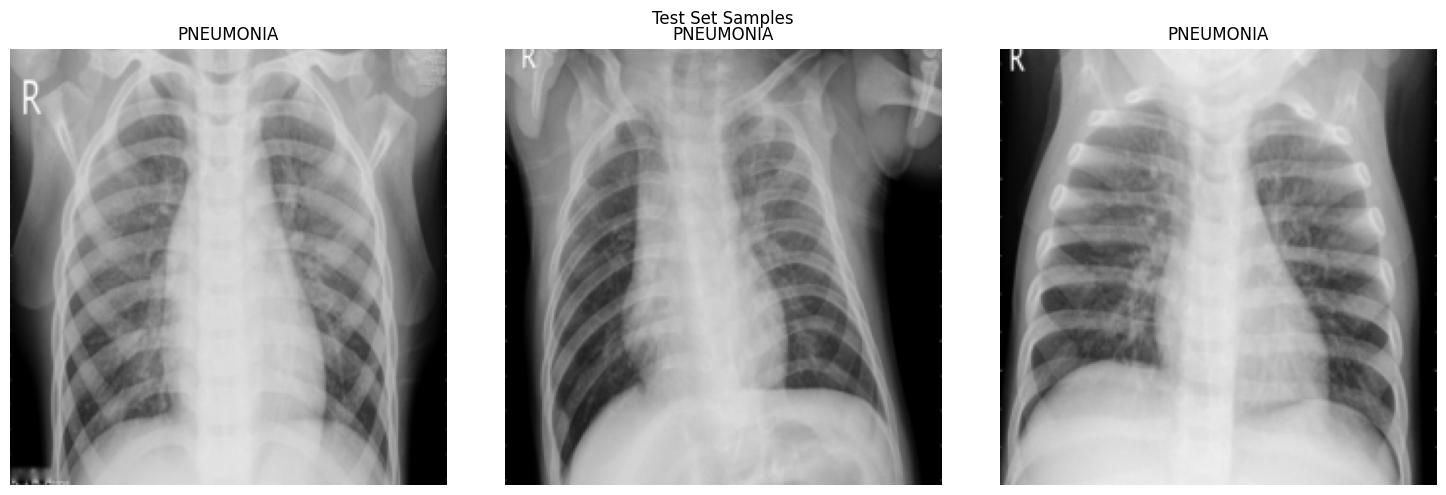


=== Image Properties ===


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.



Training Set:
  Image shape: torch.Size([64, 3, 224, 224])
  Pixel value range: [-1.0000, -0.9922]
  Label shape: torch.Size([64])
  Unique labels: [0 1]


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.



Validation Set:
  Image shape: torch.Size([64, 3, 224, 224])
  Pixel value range: [-1.0000, -0.9922]
  Label shape: torch.Size([64])
  Unique labels: [0 1]


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.



Test Set:
  Image shape: torch.Size([64, 3, 224, 224])
  Pixel value range: [-1.0000, -0.9922]
  Label shape: torch.Size([64])
  Unique labels: [1]


In [11]:
inspect_dataloaders(train_loader, val_loader, test_loader, num_samples=3)

In [12]:
# In thông tin dữ liệu
print("\nDETAILED DATASET INFORMATION:")
print("-----------------------------")
print(f"Total training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


DETAILED DATASET INFORMATION:
-----------------------------
Total training samples: 22440
Validation samples: 3984
Test samples: 4592


In [13]:
# 6. Xây dựng mô hình ViT
class ViTBinaryClassifier(nn.Module):
    def __init__(self):
        super(ViTBinaryClassifier, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=1,
            ignore_mismatched_sizes=True,
            output_hidden_states=True,
        )
        # Đóng băng các tầng ViT
        for param in self.vit.vit.parameters():
            param.requires_grad = False

        num_layers = len(self.vit.vit.encoder.layer)
        for layer in self.vit.vit.encoder.layer[-6:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        # Mở khóa CLS token
        self.vit.vit.embeddings.cls_token.requires_grad = True

    def forward(self, pixel_values, output_attentions=False):
        outputs = self.vit(pixel_values=pixel_values, output_hidden_states=True, output_attentions=output_attentions)
        logits = outputs.logits
        return torch.sigmoid(logits), logits

In [14]:
# 7. Callbacks tùy chỉnh cho PyTorch
class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_auc', mode='max'):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best_value = -float('inf') if mode == 'max' else float('inf')
    
    def __call__(self, epoch, model, logs):
        current = logs.get(self.monitor)
        if (self.mode == 'max' and current > self.best_value) or (self.mode == 'min' and current < self.best_value):
            self.best_value = current
            torch.save(model.state_dict(), self.filepath)
            print(f"Saved model checkpoint at epoch {epoch+1} with {self.monitor}: {current:.4f}")

class EarlyStopping:
    def __init__(self, monitor='val_loss', patience=7, restore_best_weights=True):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_value = float('inf')
        self.best_weights = None
        self.counter = 0
    
    def __call__(self, epoch, model, logs):
        current = logs.get(self.monitor)
        if current < self.best_value:
            self.best_value = current
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping at epoch {epoch+1}")
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        return False

class ReduceLROnPlateau:
    def __init__(self, monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6):
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.counter = 0
        self.best_value = float('inf')
    
    def __call__(self, epoch, optimizer, logs):
        current = logs.get(self.monitor)
        if current < self.best_value:
            self.best_value = current
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                for param_group in optimizer.param_groups:
                    new_lr = max(param_group['lr'] * self.factor, self.min_lr)
                    param_group['lr'] = new_lr
                    print(f"Reduced learning rate to {new_lr:.6f}")
                self.counter = 0

In [15]:
# 8. Huấn luyện mô hình
def train_model(model, train_loader, val_loader, epochs=20):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCELoss()
    
    callbacks = [
        ModelCheckpoint('best_vit_model.pth', monitor='val_auc', mode='max'),
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]
    
    history = {'loss': [], 'accuracy': [], 'auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_score = []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            sigmoid_outputs, _ = model(images)  # Lấy sigmoid outputs
            loss = criterion(sigmoid_outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (sigmoid_outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy().flatten())
            y_score.extend(sigmoid_outputs.cpu().detach().numpy().flatten())
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total if total > 0 else 0.0
        try:
            epoch_auc = roc_auc_score(y_true, y_score) if len(set(y_true)) > 1 else 0.0
        except ValueError as e:
            print(f"Warning: AUC calculation failed for training: {e}")
            epoch_auc = 0.0
        
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        history['auc'].append(epoch_auc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_y_true = []
        val_y_score = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().view(-1, 1)
                sigmoid_outputs, _ = model(images)  # Lấy sigmoid outputs
                loss = criterion(sigmoid_outputs, labels)
                val_loss += loss.item()
                predicted = (sigmoid_outputs > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                val_y_true.extend(labels.cpu().numpy().flatten())
                val_y_score.extend(sigmoid_outputs.cpu().detach().numpy().flatten())
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        try:
            val_auc = roc_auc_score(val_y_true, val_y_score) if len(set(val_y_true)) > 1 else 0.0
        except ValueError as e:
            print(f"Warning: AUC calculation failed for validation: {e}")
            val_auc = 0.0
        
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        history['val_auc'].append(val_auc)
        
        print(f"loss: {epoch_loss:.4f} - accuracy: {epoch_acc:.4f} - auc: {epoch_auc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f} - val_auc: {val_auc:.4f}")
        
        logs = {
            'loss': epoch_loss,
            'accuracy': epoch_acc,
            'auc': epoch_auc,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_auc': val_auc
        }
        for callback in callbacks:
            if isinstance(callback, EarlyStopping):
                if callback(epoch, model, logs):
                    break
            elif isinstance(callback, ReduceLROnPlateau):
                callback(epoch, optimizer, logs)
            else:
                callback(epoch, model, logs)
    
    return history

In [16]:
# 9. Đánh giá mô hình
def evaluate_model(model, test_loader, class_names=['NORMAL', 'PNEUMONIA'], debug_gradient=False):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    y_score = []
    
    criterion = nn.BCELoss()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            sigmoid_outputs, _ = model(images)
            loss = criterion(sigmoid_outputs, labels)
            test_loss += loss.item()
            predicted = (sigmoid_outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy().flatten())
            y_pred.extend(predicted.cpu().numpy().flatten())
            y_score.extend(sigmoid_outputs.cpu().numpy().flatten())
    
    test_loss /= len(test_loader)
    test_acc = correct / total if total > 0 else 0.0
    try:
        test_auc = roc_auc_score(y_true, y_score) if len(set(y_true)) > 1 else 0.0
    except ValueError as e:
        print(f"Warning: AUC calculation failed for test: {e}")
        test_auc = 0.0
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    
    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\n=== Classification Metrics ===")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")
    
    # Kiểm tra gradient (tùy chọn)
    if debug_gradient:
        print("\n=== Debugging Gradient ===")
        try:
            sample_image, sample_label = next(iter(test_loader))
            sample_image = sample_image[0].to(device).requires_grad_(True)
            _, raw_logits = model(sample_image.unsqueeze(0), output_attentions=True)
            cls_output = model.vit(sample_image.unsqueeze(0), output_hidden_states=True).hidden_states[-1][:, 0, :]
            cls_output.retain_grad()
            target_logit = raw_logits[:, 0]
            model.zero_grad()
            target_logit.backward()
            print(f"CLS gradient available: {cls_output.grad is not None}")
            if cls_output.grad is not None:
                print(f"CLS gradient shape: {cls_output.grad.shape}, min/max: {cls_output.grad.min()}, {cls_output.grad.max()}")
        except Exception as e:
            print(f"Error checking gradient: {e}")

In [17]:
def predict_single_image(image_path, model_path='best_vit_model.pth', device='cuda', class_names=['NORMAL', 'PNEUMONIA']):
    """
    Dự đoán nhãn cho một ảnh X-quang bất kỳ sử dụng mô hình ViT đã huấn luyện.
    
    Parameters:
    - image_path (str): Đường dẫn đến ảnh đầu vào (jpg, png, v.v.).
    - model_path (str): Đường dẫn đến file checkpoint của mô hình đã huấn luyện.
    - device (str): Thiết bị tính toán ('cuda' hoặc 'cpu').
    - class_names (list): Danh sách tên lớp (mặc định: ['NORMAL', 'PNEUMONIA']).
    
    Returns:
    - dict: Kết quả dự đoán gồm nhãn, xác suất, và thông báo.
    """
    try:
        # Khởi tạo thiết bị
        device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load mô hình
        model = ViTBinaryClassifier()
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()
        print(f"Loaded model from {model_path}")
        
        # Định nghĩa biến đổi ảnh (giống trong XRayDataset)
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Load và xử lý ảnh
        image = Image.open(image_path).convert('RGB')  # Chuyển sang RGB nếu là grayscale
        image_tensor = transform(image).unsqueeze(0)  # Shape: [1, 3, 224, 224]
        image_tensor = image_tensor.to(device)
        
        # Dự đoán
        with torch.no_grad():
            sigmoid_outputs, raw_logits = model(image_tensor)
            probability = sigmoid_outputs.item()  # Xác suất PNEUMONIA
            predicted = 1 if probability > 0.5 else 0
            predicted_label = class_names[predicted]
        
        # Kết quả
        result = {
            'label': predicted_label,
            'probability': probability,
            'message': f"Predicted: {predicted_label} with probability {probability:.4f}"
        }
        print(result['message'])
        
        return result
    
    except Exception as e:
        print(f"Error predicting image: {e}")
        return {
            'label': None,
            'probability': None,
            'message': f"Error: {str(e)}"
        }


In [18]:
def get_gradcam_heatmap(model, image, class_idx=0, device='cuda'):
    """
    Tính heatmap Grad-CAM cho mô hình ViT bằng gradient CLS hoặc trọng số attention.
    
    Parameters:
    - model: Mô hình ViTBinaryClassifier đã huấn luyện
    - image: Tensor hình ảnh đầu vào [3, H, W]
    - class_idx: Chỉ số lớp để tính gradient (mặc định: 0 cho phân loại nhị phân)
    - device: Thiết bị tính toán ('cuda' hoặc 'cpu')
    
    Returns:
    - numpy array: Heatmap Grad-CAM (ví dụ: [14, 14]), hoặc mảng zero nếu thất bại
    """
    try:
        model.eval()
        image = image.unsqueeze(0).to(device) 
        if not image.requires_grad:
            image.requires_grad_(True)
        
        print(f"Input image shape: {image.shape}")
        
        sigmoid_outputs, raw_logits = model(pixel_values=image, output_attentions=True)
        
        print(f"Sigmoid outputs shape: {sigmoid_outputs.shape}, Sigmoid value: {sigmoid_outputs}")
        print(f"Raw logits shape: {raw_logits.shape}, Raw logits value: {raw_logits}")
        
        outputs = model.vit(pixel_values=image, output_hidden_states=True, output_attentions=True)
        if not hasattr(outputs, 'hidden_states') or outputs.hidden_states is None:
            raise ValueError("Không có hidden_states. Đảm bảo output_hidden_states=True trong config ViT.")
        if not hasattr(outputs, 'attentions') or outputs.attentions is None:
            raise ValueError("Không có attentions. Đảm bảo output_attentions=True trong forward pass.")
        
        last_layer_output = outputs.hidden_states[-1]  
        last_attention = outputs.attentions[-1] 
        print(f"Last layer output shape: {last_layer_output.shape}")
        print(f"Last attention shape: {last_attention.shape}")
        
        target_logit = raw_logits[:, 0] 
        print(f"Target logit (pre-sigmoid): {target_logit}")
        
        cls_output = last_layer_output[:, 0, :]  
        cls_output.retain_grad()
        
        model.zero_grad()
        target_logit.backward(retain_graph=True)
        
        if cls_output.grad is None:
            print("Warning: Không có gradient cho CLS output. Kiểm tra phương án thay thế.")
            if last_layer_output.grad is None:
                print("Warning: Không có gradient cho last layer output. Sử dụng trọng số attention làm fallback.")
                attention = last_attention.mean(dim=1).detach() 
                heatmap = attention[:, 0, 1:] 
                heatmap = torch.relu(heatmap)
            else:
                cls_grad = last_layer_output.grad[:, 0, :].detach() 
                print(f"CLS gradient (từ last layer) shape: {cls_grad.shape}, min/max: {cls_grad.min()}, {cls_grad.max()}")
                attention = last_attention.mean(dim=1).detach()
                heatmap = attention[:, 0, 1:] * cls_grad.sum(dim=-1, keepdim=True)
                heatmap = torch.relu(heatmap)
        else:
            cls_grad = cls_output.grad.detach() 
            print(f"CLS gradient shape: {cls_grad.shape}, min/max: {cls_grad.min()}, {cls_grad.max()}")
            attention = last_attention.mean(dim=1).detach()
            heatmap = attention[:, 0, 1:] * cls_grad.sum(dim=-1, keepdim=True)
            heatmap = torch.relu(heatmap)
        
        print(f"Raw heatmap shape: {heatmap.shape}, Raw heatmap min/max: {heatmap.min()}, {heatmap.max()}")
        
        num_patches = heatmap.size(1)
        patch_size = int(num_patches ** 0.5) 
        heatmap = heatmap.view(1, patch_size, patch_size) 
        
        heatmap_max = torch.max(heatmap)
        if heatmap_max > 0:
            heatmap = heatmap / (heatmap_max + 1e-8)
        else:
            print("Warning: Heatmap toàn số 0. Trả về heatmap zero.")
            return np.zeros((patch_size, patch_size))
        
        heatmap = heatmap.squeeze().detach().cpu().numpy()
        print(f"Final heatmap shape: {heatmap.shape}, Final heatmap min/max: {heatmap.min()}, {heatmap.max()}")
        
        return heatmap
    
    except Exception as e:
        print(f"Error computing Grad-CAM: {e}")
        patch_size = 14
        print(f"Trả về heatmap zero có shape [{patch_size}, {patch_size}] do lỗi.")
        return np.zeros((patch_size, patch_size))

In [19]:

def visualize_gradcam(original_image, heatmap, title="Grad-CAM Visualization"):
    """
    Visualize Grad-CAM heatmap overlaid on the original image.
    
    Parameters:
    - original_image: Input image tensor [3, H, W]
    - heatmap: Grad-CAM heatmap numpy array (e.g., [14, 14])
    - title: Title for the visualization
    """
    try:
        # Convert original image to numpy and normalize for display
        original_image = original_image.permute(1, 2, 0).cpu().numpy()  # Shape: [H, W, 3]
        original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min() + 1e-8)
        
        # Check if heatmap is valid
        if heatmap is None or not np.any(heatmap):
            print("Warning: Heatmap is None or all zeros. Visualizing original image only.")
            plt.figure(figsize=(5, 5))
            plt.imshow(original_image)
            plt.title("Original Image (Heatmap Unavailable)")
            plt.axis('off')
            plt.show()
            return
        
        # Normalize and resize heatmap
        heatmap = np.maximum(heatmap, 0)  # Ensure non-negative
        heatmap_max = np.max(heatmap)
        if heatmap_max > 0:
            heatmap = heatmap / heatmap_max
        else:
            print("Warning: Heatmap is all zeros after normalization.")
            heatmap = np.zeros_like(heatmap)
        
        # Resize heatmap to match image size (224x224)
        heatmap_resized = np.array(Image.fromarray(heatmap).resize((224, 224), Image.BILINEAR))
        
        # Apply colormap
        heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]  # Shape: [224, 224, 3]
        
        # Create overlay
        overlayed_image = original_image * 0.5 + heatmap_colored * 0.5
        
        # Visualize
        plt.figure(figsize=(15, 5))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis('off')
        
        # Heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap_resized, cmap='jet')
        plt.colorbar()
        plt.title("Grad-CAM Heatmap")
        plt.axis('off')
        
        # Overlay
        plt.subplot(1, 3, 3)
        plt.imshow(overlayed_image)
        plt.title("Overlayed Image")
        plt.axis('off')
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error visualizing Grad-CAM: {e}")
        # Fallback: show original image
        plt.figure(figsize=(5, 5))
        plt.imshow(original_image)
        plt.title("Original Image (Visualization Failed)")
        plt.axis('off')
        plt.show()

In [20]:
import os
os.environ["TORCH_DYNAMO_DISABLE"] = "1"

In [21]:
# 11. Chạy pipeline
model = ViTBinaryClassifier().to(device)
history = train_model(model, train_loader, val_loader, epochs=30)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.6921 - accuracy: 0.5175 - auc: 0.5256 - val_loss: 0.6847 - val_accuracy: 0.5600 - val_auc: 0.8165
Saved model checkpoint at epoch 1 with val_auc: 0.8165

Epoch 2/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.6622 - accuracy: 0.5782 - auc: 0.6210 - val_loss: 0.6832 - val_accuracy: 0.4528 - val_auc: 0.8402
Saved model checkpoint at epoch 2 with val_auc: 0.8402

Epoch 3/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.4832 - accuracy: 0.7737 - auc: 0.8478 - val_loss: 0.3843 - val_accuracy: 0.8273 - val_auc: 0.9116
Saved model checkpoint at epoch 3 with val_auc: 0.9116

Epoch 4/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.4088 - accuracy: 0.8242 - auc: 0.8942 - val_loss: 0.3519 - val_accuracy: 0.8479 - val_auc: 0.9244
Saved model checkpoint at epoch 4 with val_auc: 0.9244

Epoch 5/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.3858 - accuracy: 0.8348 - auc: 0.9061 - val_loss: 0.3207 - val_accuracy: 0.8687 - val_auc: 0.9391
Saved model checkpoint at epoch 5 with val_auc: 0.9391

Epoch 6/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.3722 - accuracy: 0.8402 - auc: 0.9128 - val_loss: 0.3440 - val_accuracy: 0.8514 - val_auc: 0.9345

Epoch 7/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.3560 - accuracy: 0.8512 - auc: 0.9207 - val_loss: 0.3546 - val_accuracy: 0.8524 - val_auc: 0.9434
Saved model checkpoint at epoch 7 with val_auc: 0.9434

Epoch 8/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.3398 - accuracy: 0.8610 - auc: 0.9272 - val_loss: 0.3010 - val_accuracy: 0.8727 - val_auc: 0.9551
Saved model checkpoint at epoch 8 with val_auc: 0.9551

Epoch 9/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.3226 - accuracy: 0.8689 - auc: 0.9344 - val_loss: 0.2776 - val_accuracy: 0.8800 - val_auc: 0.9575
Saved model checkpoint at epoch 9 with val_auc: 0.9575

Epoch 10/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.3077 - accuracy: 0.8763 - auc: 0.9400 - val_loss: 0.2689 - val_accuracy: 0.8956 - val_auc: 0.9575
Saved model checkpoint at epoch 10 with val_auc: 0.9575

Epoch 11/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.3038 - accuracy: 0.8772 - auc: 0.9415 - val_loss: 0.2761 - val_accuracy: 0.8830 - val_auc: 0.9561

Epoch 12/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2978 - accuracy: 0.8807 - auc: 0.9433 - val_loss: 0.2770 - val_accuracy: 0.9026 - val_auc: 0.9639
Saved model checkpoint at epoch 12 with val_auc: 0.9639

Epoch 13/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2935 - accuracy: 0.8838 - auc: 0.9448 - val_loss: 0.2363 - val_accuracy: 0.9091 - val_auc: 0.9664
Saved model checkpoint at epoch 13 with val_auc: 0.9664

Epoch 14/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2930 - accuracy: 0.8853 - auc: 0.9446 - val_loss: 0.2287 - val_accuracy: 0.9081 - val_auc: 0.9679
Saved model checkpoint at epoch 14 with val_auc: 0.9679

Epoch 15/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2893 - accuracy: 0.8844 - auc: 0.9463 - val_loss: 0.2443 - val_accuracy: 0.9061 - val_auc: 0.9663

Epoch 16/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2796 - accuracy: 0.8908 - auc: 0.9490 - val_loss: 0.2271 - val_accuracy: 0.9162 - val_auc: 0.9690
Saved model checkpoint at epoch 16 with val_auc: 0.9690

Epoch 17/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2822 - accuracy: 0.8885 - auc: 0.9486 - val_loss: 0.2530 - val_accuracy: 0.8973 - val_auc: 0.9624

Epoch 18/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2841 - accuracy: 0.8898 - auc: 0.9474 - val_loss: 0.2820 - val_accuracy: 0.8793 - val_auc: 0.9699
Saved model checkpoint at epoch 18 with val_auc: 0.9699

Epoch 19/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2827 - accuracy: 0.8900 - auc: 0.9478 - val_loss: 0.2793 - val_accuracy: 0.8873 - val_auc: 0.9690
Reduced learning rate to 0.000020

Epoch 20/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2520 - accuracy: 0.9033 - auc: 0.9570 - val_loss: 0.2170 - val_accuracy: 0.9177 - val_auc: 0.9710
Saved model checkpoint at epoch 20 with val_auc: 0.9710

Epoch 21/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2478 - accuracy: 0.9057 - auc: 0.9583 - val_loss: 0.2226 - val_accuracy: 0.9179 - val_auc: 0.9727
Saved model checkpoint at epoch 21 with val_auc: 0.9727

Epoch 22/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2497 - accuracy: 0.9061 - auc: 0.9581 - val_loss: 0.2151 - val_accuracy: 0.9169 - val_auc: 0.9721

Epoch 23/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2457 - accuracy: 0.9084 - auc: 0.9588 - val_loss: 0.2048 - val_accuracy: 0.9257 - val_auc: 0.9751
Saved model checkpoint at epoch 23 with val_auc: 0.9751

Epoch 24/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2416 - accuracy: 0.9081 - auc: 0.9602 - val_loss: 0.1998 - val_accuracy: 0.9292 - val_auc: 0.9747

Epoch 25/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2426 - accuracy: 0.9076 - auc: 0.9603 - val_loss: 0.2169 - val_accuracy: 0.9202 - val_auc: 0.9757
Saved model checkpoint at epoch 25 with val_auc: 0.9757

Epoch 26/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2381 - accuracy: 0.9121 - auc: 0.9615 - val_loss: 0.1949 - val_accuracy: 0.9345 - val_auc: 0.9762
Saved model checkpoint at epoch 26 with val_auc: 0.9762

Epoch 27/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2420 - accuracy: 0.9098 - auc: 0.9602 - val_loss: 0.2012 - val_accuracy: 0.9307 - val_auc: 0.9751

Epoch 28/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2354 - accuracy: 0.9142 - auc: 0.9611 - val_loss: 0.1994 - val_accuracy: 0.9295 - val_auc: 0.9755

Epoch 29/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2364 - accuracy: 0.9127 - auc: 0.9614 - val_loss: 0.1859 - val_accuracy: 0.9378 - val_auc: 0.9770
Saved model checkpoint at epoch 29 with val_auc: 0.9770

Epoch 30/30


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_re

loss: 0.2324 - accuracy: 0.9152 - auc: 0.9621 - val_loss: 0.1803 - val_accuracy: 0.9418 - val_auc: 0.9777
Saved model checkpoint at epoch 30 with val_auc: 0.9777


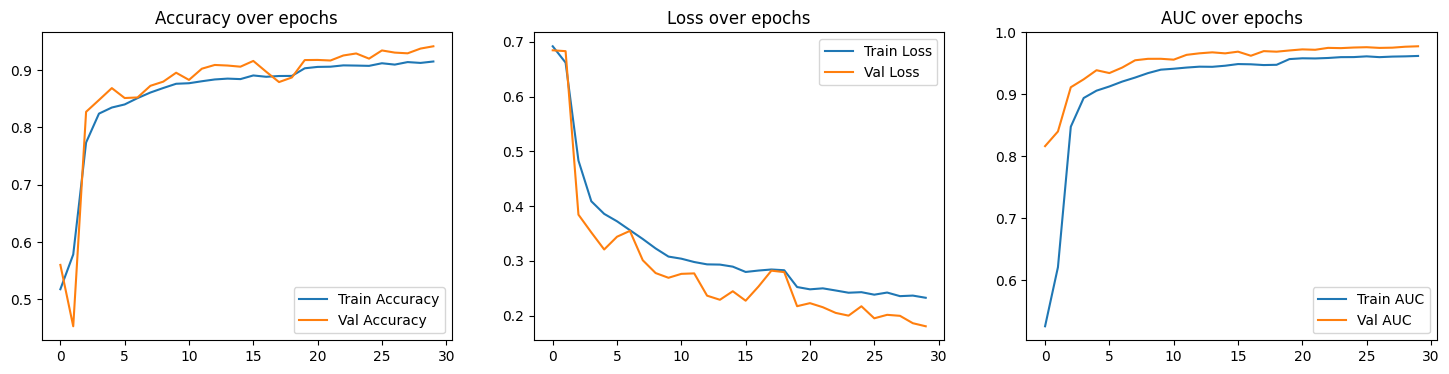

In [22]:
# Vẽ đồ thị kết quả
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(history['auc'], label='Train AUC')
plt.plot(history['val_auc'], label='Val AUC')
plt.title('AUC over epochs')
plt.legend()
plt.show()

# Lưu mô hình
torch.save(model.state_dict(), 'pneumonia_vit_model.pth')

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Test Loss: 0.2051
Test Accuracy: 0.9301
Test AUC: 0.9737


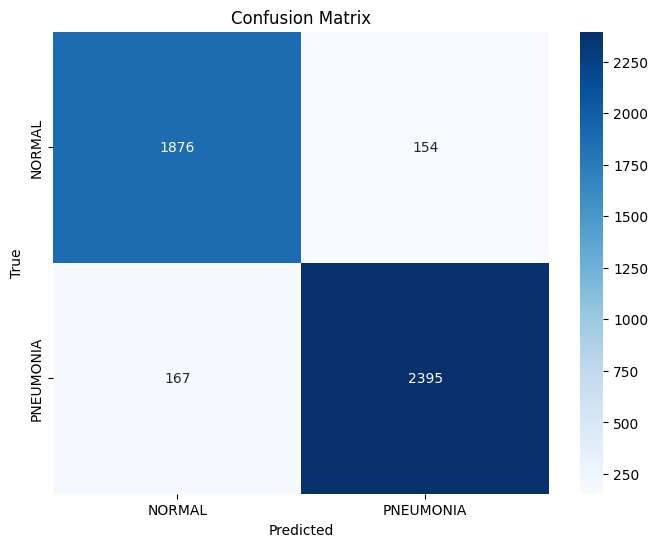


=== Classification Metrics ===
NORMAL:
  Precision: 0.9183
  Recall: 0.9241
  F1-Score: 0.9212
PNEUMONIA:
  Precision: 0.9396
  Recall: 0.9348
  F1-Score: 0.9372


In [23]:
evaluate_model(model, test_loader)

In [24]:
torch.save(model.state_dict(), 'pneumonia_vit_model.pth')

In [ ]:
model_path = "/kaggle/working/pneumonia_vit_model.pth"
try:
    model = ViTBinaryClassifier().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the model file exists and is compatible with ViTBinaryClassifier.")


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Input image shape: torch.Size([1, 3, 224, 224])
Sigmoid outputs shape: torch.Size([1, 1]), Sigmoid value: tensor([[0.9857]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Raw logits shape: torch.Size([1, 1]), Raw logits value: tensor([[4.2308]], device='cuda:0', grad_fn=<AddmmBackward0>)
Last layer output shape: torch.Size([1, 197, 768])
Last attention shape: torch.Size([1, 12, 197, 197])
Target logit (pre-sigmoid): tensor([4.2308], device='cuda:0', grad_fn=<SelectBackward0>)
Raw heatmap shape: torch.Size([1, 196]), Raw heatmap min/max: 4.30174040957354e-05, 0.14070391654968262
Final heatmap shape: (14, 14), Final heatmap min/max: 0.00030572994728572667, 0.9999998807907104


/tmp/ipykernel_35/2431789759.py:49: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  if last_layer_output.grad is None:


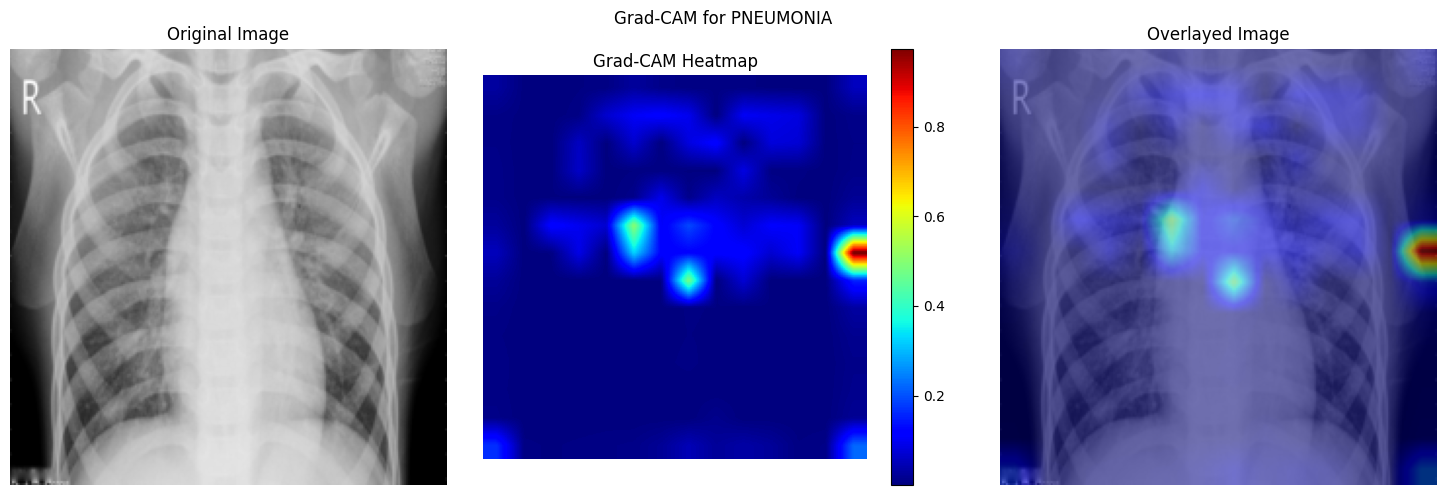

Input image shape: torch.Size([1, 3, 224, 224])
Sigmoid outputs shape: torch.Size([1, 1]), Sigmoid value: tensor([[0.9568]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Raw logits shape: torch.Size([1, 1]), Raw logits value: tensor([[3.0977]], device='cuda:0', grad_fn=<AddmmBackward0>)
Last layer output shape: torch.Size([1, 197, 768])
Last attention shape: torch.Size([1, 12, 197, 197])
Target logit (pre-sigmoid): tensor([3.0977], device='cuda:0', grad_fn=<SelectBackward0>)
Raw heatmap shape: torch.Size([1, 196]), Raw heatmap min/max: 2.1745763660874218e-05, 0.1163848266005516
Final heatmap shape: (14, 14), Final heatmap min/max: 0.0001868436229415238, 0.9999999403953552


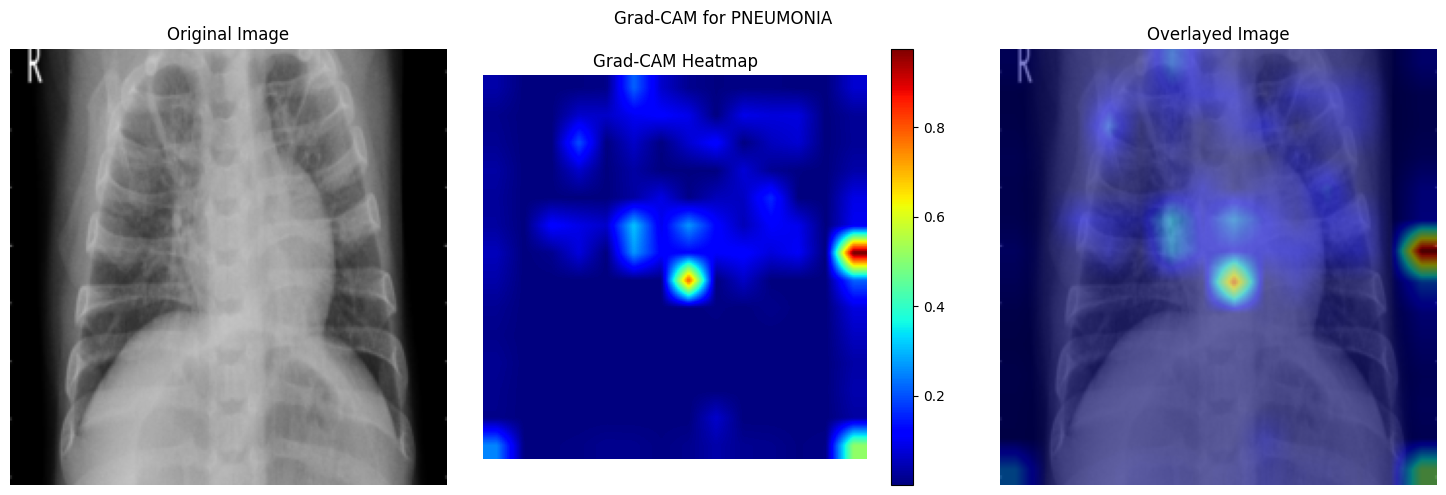

Input image shape: torch.Size([1, 3, 224, 224])
Sigmoid outputs shape: torch.Size([1, 1]), Sigmoid value: tensor([[0.9990]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Raw logits shape: torch.Size([1, 1]), Raw logits value: tensor([[6.9153]], device='cuda:0', grad_fn=<AddmmBackward0>)
Last layer output shape: torch.Size([1, 197, 768])
Last attention shape: torch.Size([1, 12, 197, 197])
Target logit (pre-sigmoid): tensor([6.9153], device='cuda:0', grad_fn=<SelectBackward0>)
Raw heatmap shape: torch.Size([1, 196]), Raw heatmap min/max: 5.319703632267192e-05, 0.1393975019454956
Final heatmap shape: (14, 14), Final heatmap min/max: 0.00038162112468853593, 0.9999998807907104


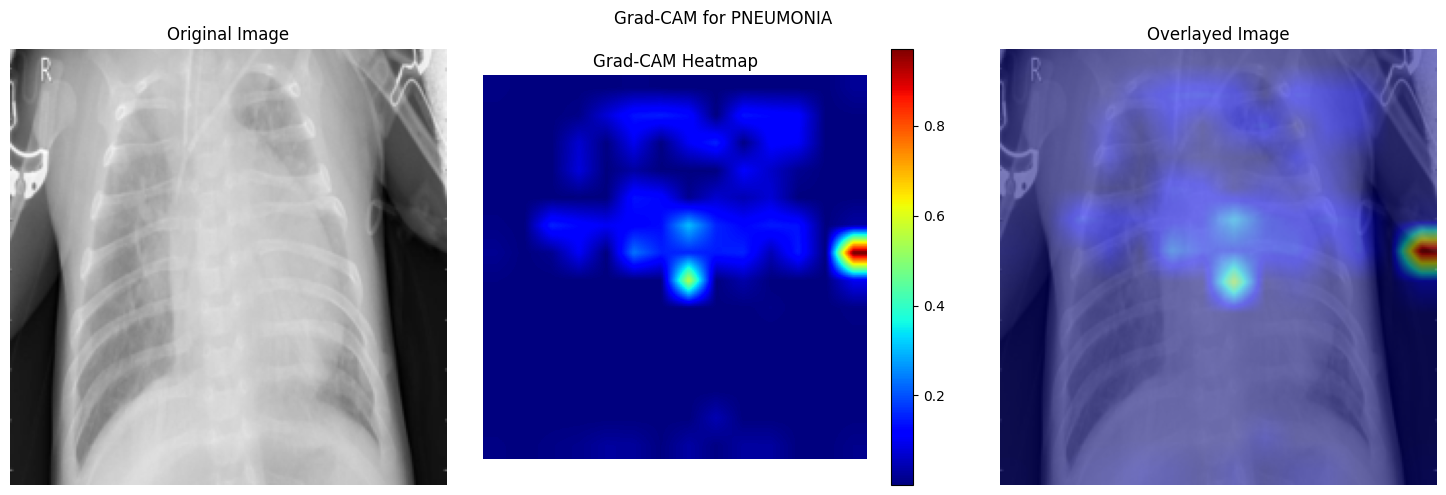

Input image shape: torch.Size([1, 3, 224, 224])
Sigmoid outputs shape: torch.Size([1, 1]), Sigmoid value: tensor([[0.9936]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Raw logits shape: torch.Size([1, 1]), Raw logits value: tensor([[5.0397]], device='cuda:0', grad_fn=<AddmmBackward0>)
Last layer output shape: torch.Size([1, 197, 768])
Last attention shape: torch.Size([1, 12, 197, 197])
Target logit (pre-sigmoid): tensor([5.0397], device='cuda:0', grad_fn=<SelectBackward0>)
Raw heatmap shape: torch.Size([1, 196]), Raw heatmap min/max: 3.985252988059074e-05, 0.25167447328567505
Final heatmap shape: (14, 14), Final heatmap min/max: 0.00015834951773285866, 1.0


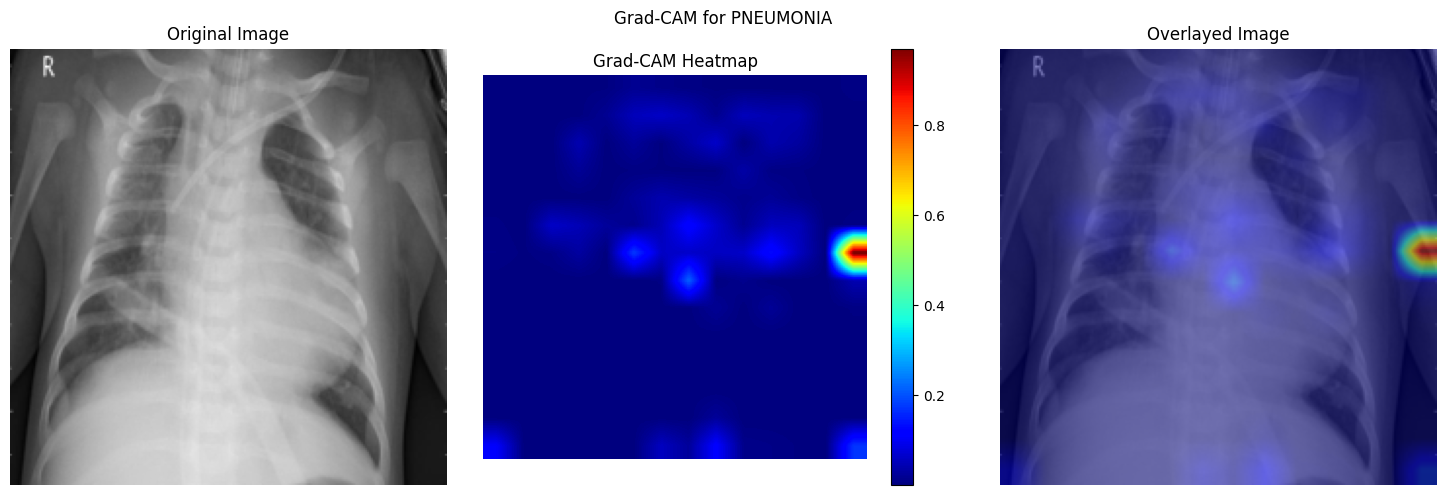

Input image shape: torch.Size([1, 3, 224, 224])
Sigmoid outputs shape: torch.Size([1, 1]), Sigmoid value: tensor([[0.9982]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Raw logits shape: torch.Size([1, 1]), Raw logits value: tensor([[6.3286]], device='cuda:0', grad_fn=<AddmmBackward0>)
Last layer output shape: torch.Size([1, 197, 768])
Last attention shape: torch.Size([1, 12, 197, 197])
Target logit (pre-sigmoid): tensor([6.3286], device='cuda:0', grad_fn=<SelectBackward0>)
Raw heatmap shape: torch.Size([1, 196]), Raw heatmap min/max: 6.63752289256081e-05, 0.23304657638072968
Final heatmap shape: (14, 14), Final heatmap min/max: 0.0002848152653314173, 0.9999999403953552


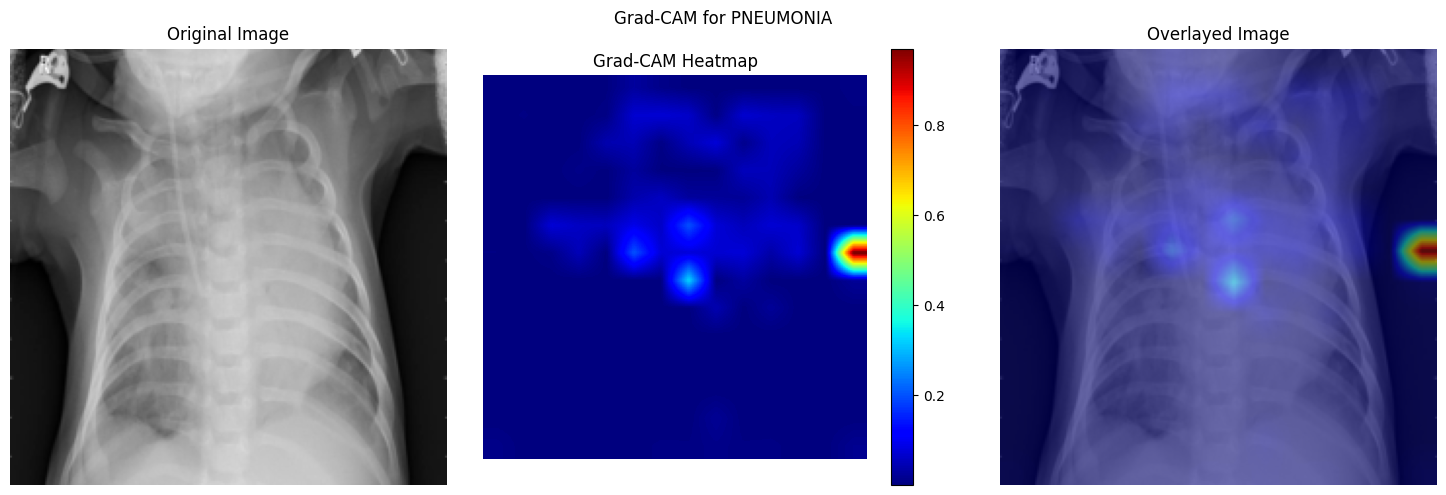

In [25]:
# Tính Grad-CAM cho một số ảnh từ test_loader
try:
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:  # Giới hạn ở 5 ảnh
            break
        sample_image, sample_label = images[0], labels[0].item()
        heatmap = get_gradcam_heatmap(model, sample_image, class_idx=sample_label, device=device)
        visualize_gradcam(sample_image, heatmap, title=f"Grad-CAM for {'PNEUMONIA' if sample_label == 1 else 'NORMAL'}")
except Exception as e:
    print(f"Error processing Grad-CAM: {e}")
    print("Please check test_loader and model configuration.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model from /kaggle/working/pneumonia_vit_model.pth
Predicted: PNEUMONIA with probability 0.5688
Input image shape: torch.Size([1, 3, 224, 224])
Sigmoid outputs shape: torch.Size([1, 1]), Sigmoid value: tensor([[0.5688]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Raw logits shape: torch.Size([1, 1]), Raw logits value: tensor([[0.2771]], device='cuda:0', grad_fn=<AddmmBackward0>)
Last layer output shape: torch.Size([1, 197, 768])
Last attention shape: torch.Size([1, 12, 197, 197])
Target logit (pre-sigmoid): tensor([0.2771], device='cuda:0', grad_fn=<SelectBackward0>)
Raw heatmap shape: torch.Size([1, 196]), Raw heatmap min/max: 0.00014824802929069847, 0.0345693901181221
Final heatmap shape: (14, 14), Final heatmap min/max: 0.004288417752832174, 0.9999997019767761


/tmp/ipykernel_35/2598174421.py:151: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  if last_layer_output.grad is None:


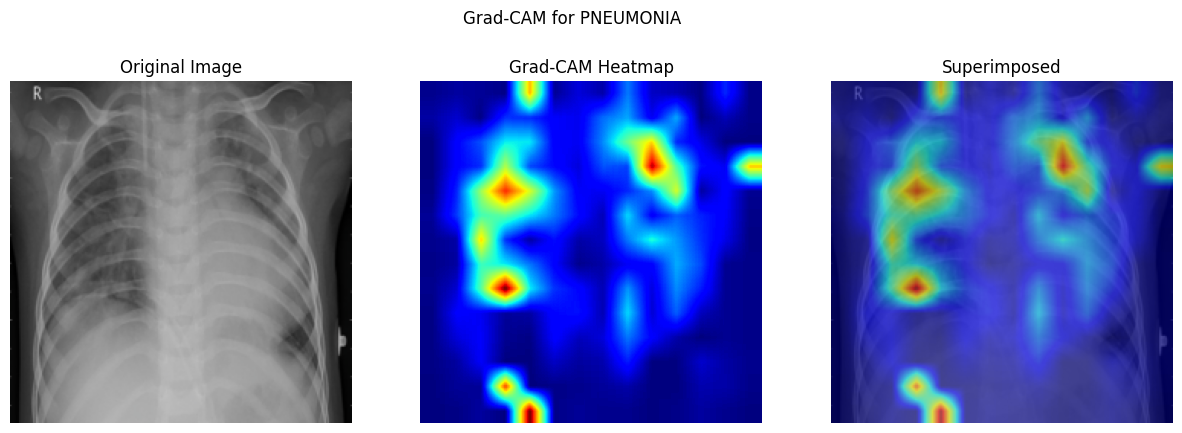

{'label': 'PNEUMONIA', 'probability': 0.568832278251648, 'message': 'Predicted: PNEUMONIA with probability 0.5688'}


In [34]:
# Mã trước đó (setup_dataloaders, XRayDataset, train_model, evaluate_model, 
# ModelCheckpoint, EarlyStopping, ReduceLROnPlateau) giữ nguyên từ artifact version ID cf94bf8d-9389-4e6f-bbf8-4f3a830de4df.
# Thêm hàm predict_and_visualize_gradcam để dự đoán và vẽ Grad-CAM cho một ảnh.

import os
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Cấu hình môi trường Kaggle
os.environ["TORCH_DYNAMO_DISABLE"] = "1"

# 6. Xây dựng mô hình ViT
class ViTBinaryClassifier(nn.Module):
    def __init__(self):
        super(ViTBinaryClassifier, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=1,
            ignore_mismatched_sizes=True,
            output_hidden_states=True,
        )
        # Đóng băng các tầng ViT
        for param in self.vit.vit.parameters():
            param.requires_grad = False

        # Mở khóa 6 tầng cuối
        num_layers = len(self.vit.vit.encoder.layer)
        for layer in self.vit.vit.encoder.layer[-6:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        # Mở khóa CLS token
        self.vit.vit.embeddings.cls_token.requires_grad = True
    
    def forward(self, pixel_values, output_attentions=False):
        outputs = self.vit(pixel_values=pixel_values, output_hidden_states=True, output_attentions=output_attentions)
        logits = outputs.logits
        return torch.sigmoid(logits), logits  # Trả về sigmoid và logit thô

# Hàm vẽ Grad-CAM (giả định từ pipeline)
def visualize_gradcam(image, heatmap, title="Grad-CAM", alpha=0.6):
    """
    Vẽ ảnh gốc, heatmap Grad-CAM, và ảnh chồng lấn.
    
    Parameters:
    - image: Tensor ảnh đầu vào [3, H, W]
    - heatmap: Mảng numpy [H, W] (ví dụ: [14, 14])
    - title: Tiêu đề biểu đồ
    - alpha: Độ trong suốt của heatmap khi chồng lấn
    """
    try:
        # Chuyển tensor ảnh về numpy và chuẩn hóa
        image = image.cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
        
        # Resize heatmap về kích thước ảnh
        heatmap = np.uint8(255 * heatmap)  # Chuẩn hóa về [0, 255]
        heatmap = Image.fromarray(heatmap).resize((image.shape[1], image.shape[0]), resample=Image.BILINEAR)
        heatmap = np.array(heatmap) / 255.0
        
        # Tạo heatmap màu
        heatmap_color = plt.cm.jet(heatmap)[:, :, :3]  # [H, W, 3]
        
        # Ảnh chồng lấn
        superimposed_img = heatmap_color * alpha + image * (1 - alpha)
        superimposed_img = superimposed_img.clip(0, 1)
        
        # Vẽ ba biểu đồ
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("Grad-CAM Heatmap")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(superimposed_img)
        plt.title("Superimposed")
        plt.axis('off')
        
        plt.suptitle(title)
        plt.show()
    
    except Exception as e:
        print(f"Error visualizing Grad-CAM: {e}")
        plt.figure()
        plt.imshow(image)
        plt.title("Original Image (Visualization Failed)")
        plt.axis('off')
        plt.show()

# Hàm tính Grad-CAM
def get_gradcam_heatmap(model, image, class_idx=0, device='cuda'):
    """
    Tính heatmap Grad-CAM cho mô hình ViT bằng gradient CLS hoặc trọng số attention.
    
    Parameters:
    - model: Mô hình ViTBinaryClassifier đã huấn luyện
    - image: Tensor hình ảnh đầu vào [3, H, W]
    - class_idx: Chỉ số lớp để tính gradient (mặc định: 0 cho phân loại nhị phân)
    - device: Thiết bị tính toán ('cuda' hoặc 'cpu')
    
    Returns:
    - numpy array: Heatmap Grad-CAM (ví dụ: [14, 14]), hoặc mảng zero nếu thất bại
    """
    try:
        model.eval()
        image = image.unsqueeze(0).to(device)  # Shape: [1, 3, H, W]
        if not image.requires_grad:
            image.requires_grad_(True)
        
        print(f"Input image shape: {image.shape}")
        
        sigmoid_outputs, raw_logits = model(pixel_values=image, output_attentions=True)
        
        print(f"Sigmoid outputs shape: {sigmoid_outputs.shape}, Sigmoid value: {sigmoid_outputs}")
        print(f"Raw logits shape: {raw_logits.shape}, Raw logits value: {raw_logits}")
        
        outputs = model.vit(pixel_values=image, output_hidden_states=True, output_attentions=True)
        if not hasattr(outputs, 'hidden_states') or outputs.hidden_states is None:
            raise ValueError("Không có hidden_states. Đảm bảo output_hidden_states=True trong config ViT.")
        if not hasattr(outputs, 'attentions') or outputs.attentions is None:
            raise ValueError("Không có attentions. Đảm bảo output_attentions=True trong forward pass.")
        
        last_layer_output = outputs.hidden_states[-1]  # Shape: [1, 197, 768]
        last_attention = outputs.attentions[-1]  # Shape: [1, num_heads, 197, 197]
        print(f"Last layer output shape: {last_layer_output.shape}")
        print(f"Last attention shape: {last_attention.shape}")
        
        target_logit = raw_logits[:, 0]  # Shape: [1]
        print(f"Target logit (pre-sigmoid): {target_logit}")
        
        cls_output = last_layer_output[:, 0, :]  # Shape: [1, 768]
        cls_output.retain_grad()
        
        model.zero_grad()
        target_logit.backward(retain_graph=True)
        
        if cls_output.grad is None:
            print("Warning: Không có gradient cho CLS output. Kiểm tra phương án thay thế.")
            if last_layer_output.grad is None:
                print("Warning: Không có gradient cho last layer output. Sử dụng trọng số attention làm fallback.")
                attention = last_attention.mean(dim=1).detach()  # Shape: [1, 197, 197]
                heatmap = attention[:, 0, 1:]  # CLS-to-patches: [1, 196]
                heatmap = torch.relu(heatmap)
            else:
                cls_grad = last_layer_output.grad[:, 0, :].detach()  # Shape: [1, 768]
                print(f"CLS gradient (từ last layer) shape: {cls_grad.shape}, min/max: {cls_grad.min()}, {cls_grad.max()}")
                attention = last_attention.mean(dim=1).detach()
                heatmap = attention[:, 0, 1:] * cls_grad.sum(dim=-1, keepdim=True)
                heatmap = torch.relu(heatmap)
        else:
            cls_grad = cls_output.grad.detach()  # Shape: [1, 768]
            print(f"CLS gradient shape: {cls_grad.shape}, min/max: {cls_grad.min()}, {cls_grad.max()}")
            attention = last_attention.mean(dim=1).detach()
            heatmap = attention[:, 0, 1:] * cls_grad.sum(dim=-1, keepdim=True)
            heatmap = torch.relu(heatmap)
        
        print(f"Raw heatmap shape: {heatmap.shape}, Raw heatmap min/max: {heatmap.min()}, {heatmap.max()}")
        
        num_patches = heatmap.size(1)
        patch_size = int(num_patches ** 0.5)  # ví dụ: 14 cho 196 patch (224/16)
        heatmap = heatmap.view(1, patch_size, patch_size)  # Shape: [1, 14, 14]
        
        heatmap_max = torch.max(heatmap)
        if heatmap_max > 0:
            heatmap = heatmap / (heatmap_max + 1e-8)
        else:
            print("Warning: Heatmap toàn số 0. Trả về heatmap zero.")
            return np.zeros((patch_size, patch_size))
        
        heatmap = heatmap.squeeze().detach().cpu().numpy()  # Shape: [14, 14]
        print(f"Final heatmap shape: {heatmap.shape}, Final heatmap min/max: {heatmap.min()}, {heatmap.max()}")
        
        return heatmap
    
    except Exception as e:
        print(f"Error computing Grad-CAM: {e}")
        patch_size = 14
        print(f"Trả về heatmap zero có shape [{patch_size}, {patch_size}] do lỗi.")
        return np.zeros((patch_size, patch_size))

# Hàm dự đoán và vẽ Grad-CAM
def predict_and_visualize_gradcam(image_path, model_path='best_vit_model.pth', device='cuda', class_names=['NORMAL', 'PNEUMONIA']):
    """
    Dự đoán nhãn và vẽ Grad-CAM cho một ảnh X-quang bất kỳ sử dụng mô hình ViT đã huấn luyện.
    
    Parameters:
    - image_path (str): Đường dẫn đến ảnh đầu vào (jpg, png, v.v.).
    - model_path (str): Đường dẫn đến file checkpoint của mô hình đã huấn luyện.
    - device (str): Thiết bị tính toán ('cuda' hoặc 'cpu').
    - class_names (list): Danh sách tên lớp (mặc định: ['NORMAL', 'PNEUMONIA']).
    
    Returns:
    - dict: Kết quả dự đoán gồm nhãn, xác suất, và thông báo.
    """
    try:
        # Khởi tạo thiết bị
        device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load mô hình
        model = ViTBinaryClassifier()
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()
        print(f"Loaded model from {model_path}")
        
        # Định nghĩa biến đổi ảnh (giống trong XRayDataset)
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Load và xử lý ảnh
        image = Image.open(image_path).convert('RGB')  # Chuyển sang RGB nếu là grayscale
        image_tensor = transform(image)  # Shape: [3, 224, 224]
        image_tensor_input = image_tensor.unsqueeze(0).to(device)  # Shape: [1, 3, 224, 224]
        
        # Dự đoán
        with torch.no_grad():
            sigmoid_outputs, _ = model(image_tensor_input)
            probability = sigmoid_outputs.item()  # Xác suất PNEUMONIA
            predicted = 1 if probability > 0.5 else 0
            predicted_label = class_names[predicted]
        
        # Kết quả dự đoán
        result = {
            'label': predicted_label,
            'probability': probability,
            'message': f"Predicted: {predicted_label} with probability {probability:.4f}"
        }
        print(result['message'])
        
        # Tính và vẽ Grad-CAM
        heatmap = get_gradcam_heatmap(model, image_tensor, class_idx=predicted, device=device)
        visualize_gradcam(image_tensor, heatmap, title=f"Grad-CAM for {predicted_label}")
        
        return result
    
    except Exception as e:
        print(f"Error processing image or Grad-CAM: {e}")
        return {
            'label': None,
            'probability': None,
            'message': f"Error: {str(e)}"
        }

# Mã chạy pipeline (ví dụ):

# ... (setup_dataloaders, XRayDataset, train_model, evaluate_model giữ nguyên)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dự đoán và vẽ Grad-CAM cho một ảnh
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_485.jpeg"  # Thay bằng đường dẫn thực tế
result = predict_and_visualize_gradcam(image_path, model_path='/kaggle/working/pneumonia_vit_model.pth', device=device)
print(result)